In [1]:
import glob
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import cv2
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
if RunningInCOLAB:
    path = "/content/gdrive/MyDrive/ItCV"
else:
    path = os.path.dirname(__vsc_ipynb_file__)
data_path = path+"/data"
os.chdir(path)

Mounted at /content/gdrive


In [3]:
edible = glob.glob(f"{data_path}/edible/*")
poisonous = glob.glob(f"{data_path}/poisonous/*")

# 1: an duoc, 0: co doc
x, y = edible + poisonous, [1]*len(edible)+[0]*len(poisonous)

<Axes: ylabel='count'>

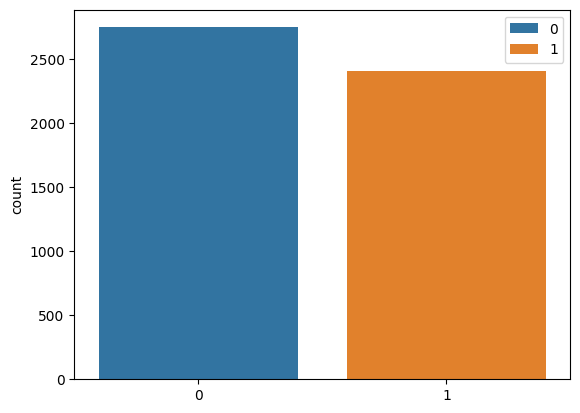

In [4]:
sns.countplot(x = y, hue = y)

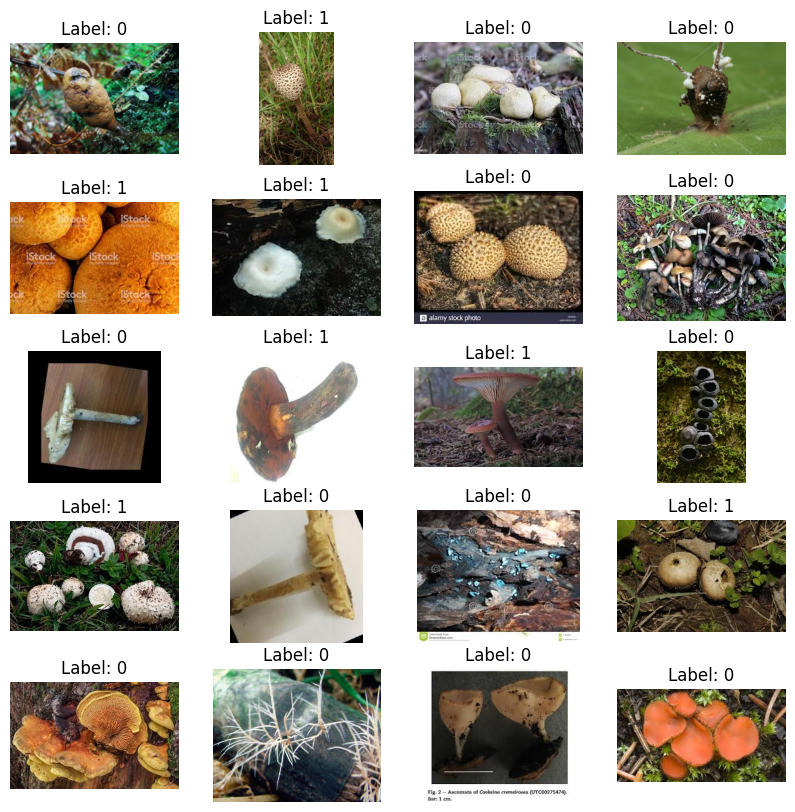

In [5]:
image_paths = x
labels = y

indices = random.sample(range(len(image_paths)), 20)
selected_paths = [image_paths[i] for i in indices]
selected_labels = [labels[i] for i in indices]

plt.figure(figsize=(10, 10))
for i, path in enumerate(selected_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    plt.title(f'Label: {selected_labels[i]}')
    plt.axis('off')
plt.show()

# Hist 8 **8**

In [6]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.imread(image_path)
    #image = cv2.resize(image, (128, 128))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 179, 0, 256, 0, 256])

    cv2.normalize(hist, hist)

    return hist.flatten()

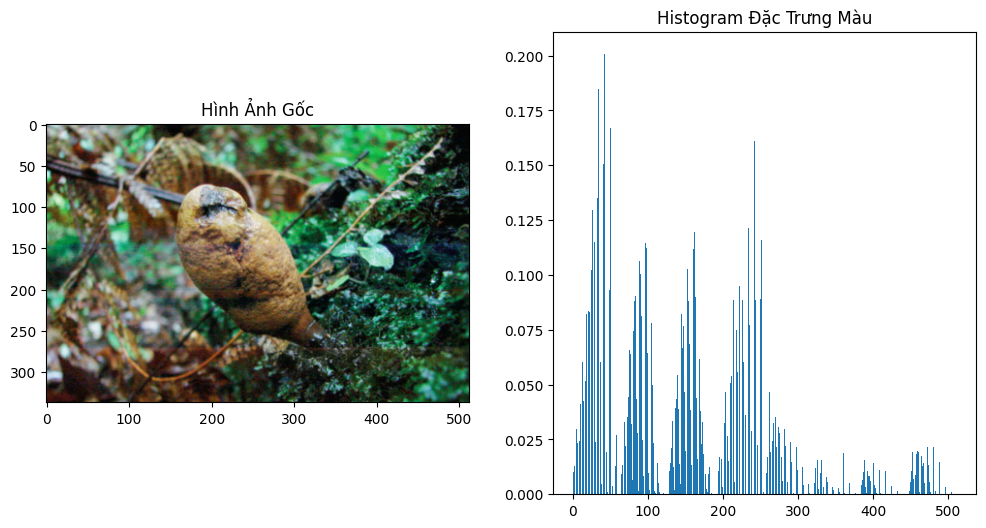

In [7]:
image = cv2.imread(selected_paths[0])
feature_vector = extract_color_histogram(selected_paths[0])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Hình Ảnh Gốc')

plt.subplot(1, 2, 2)
plt.bar(range(len(feature_vector)), feature_vector)
plt.title('Histogram Đặc Trưng Màu')
plt.show()

In [8]:
from tqdm import tqdm
X=[]
for i in tqdm(x):
  feature_vector = extract_color_histogram(i)
  X.append(feature_vector)

100%|██████████| 5155/5155 [17:35<00:00,  4.88it/s]


In [9]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
test_path = "/content/gdrive/MyDrive/ItCV/test_data"
edible = glob.glob(f"{test_path}/edible/*")
poisonous = glob.glob(f"{test_path}/poisonous/*")
x, y_TestData = edible + poisonous, [1]*len(edible)+[0]*len(poisonous)

X_TestData=[]
for i in tqdm(x):
  feature_vector = extract_color_histogram(i)
  X_TestData.append(feature_vector)

100%|██████████| 83/83 [00:31<00:00,  2.60it/s]


# **KNN**

In [11]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier(metric="cosine", n_jobs=1, n_neighbors=2)


clf.fit(xTrain, yTrain)

y_pre = clf.predict(xTest)
print(accuracy_score(yTest, y_pre))

0.7972841901066925


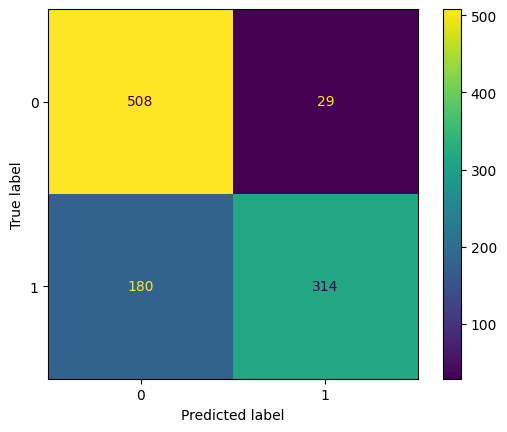

In [12]:
cm = confusion_matrix(yTest, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
disp.plot()

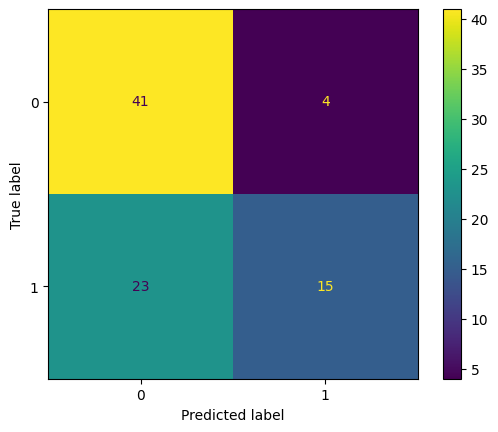

In [20]:
y_pre = clf.predict(X_TestData)
cm = confusion_matrix(y_TestData, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
disp.plot()

# **SVM**

In [21]:
from sklearn.metrics import accuracy_score,classification_report
clf = SVC(C=0.5, gamma=2.0, kernel="poly", degree=15)
clf.fit(xTrain, yTrain)
y_pre = clf.predict(xTest)
print(accuracy_score(yTest, y_pre))

0.8079534432589719


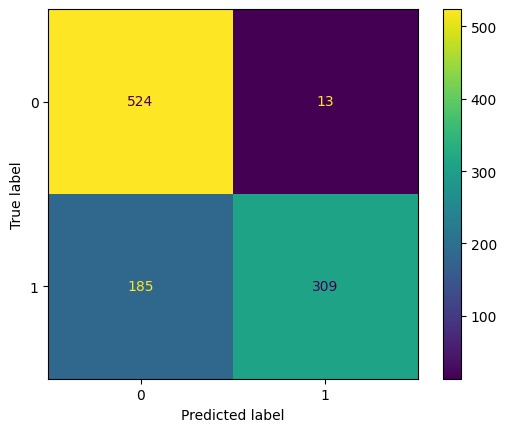

In [22]:
cm = confusion_matrix(yTest, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
disp.plot()

0.7349397590361446


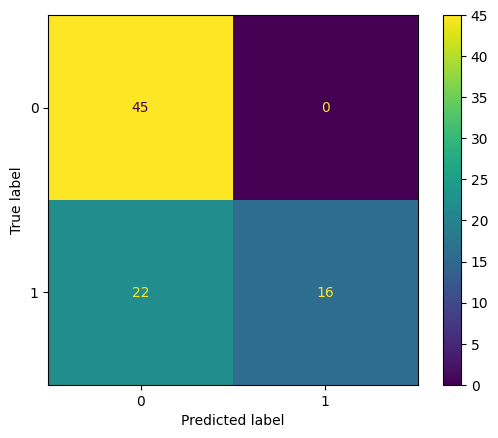

In [23]:
y_pre = clf.predict(X_TestData)
print(accuracy_score(y_TestData, y_pre))

cm = confusion_matrix(y_TestData, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# **LR**

In [30]:
from sklearn.metrics import accuracy_score,classification_report
clf = LogisticRegression()
clf.fit(xTrain, yTrain)
y_pre = clf.predict_proba(xTest)
y_pre_lab = []
#print(y_pre)
for i in y_pre[:, 1]:
    if i >= 0.61:
        y_pre_lab.append(1)
    else:
        y_pre_lab.append(0)
print(accuracy_score(yTest, y_pre_lab))


0.7468477206595538


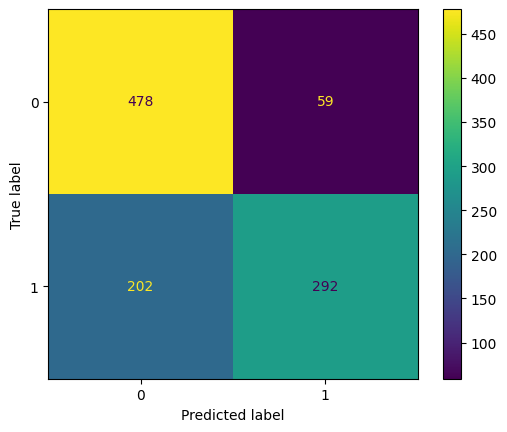

In [31]:
cm = confusion_matrix(yTest, y_pre_lab)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

0.7710843373493976


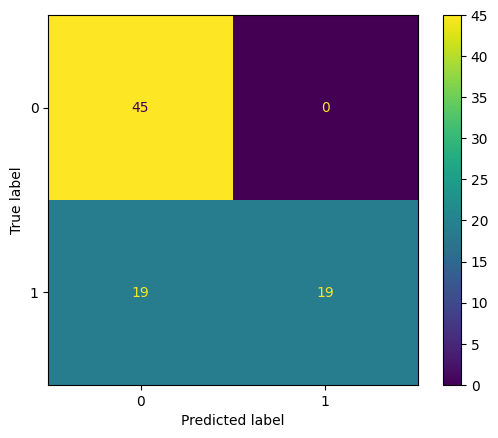

In [34]:
y_pre = clf.predict_proba(X_TestData)
y_pre_lab = []
for i in y_pre[:, 1]:
    if i >= 0.61:
        y_pre_lab.append(1)
    else:
        y_pre_lab.append(0)
print(accuracy_score(y_TestData, y_pre_lab))
cm = confusion_matrix(y_TestData, y_pre_lab)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

# Random Forest

In [46]:
from sklearn.metrics import accuracy_score,classification_report
clf = DecisionTreeClassifier(random_state=42, max_depth= 5, min_samples_leaf=90, criterion= 'entropy')
clf.fit(xTrain, yTrain)
import joblib
joblib.dump(clf, 'DT_model.pkl')
y_pre = clf.predict(xTest)
print(accuracy_score(yTest, y_pre))

0.7410281280310378


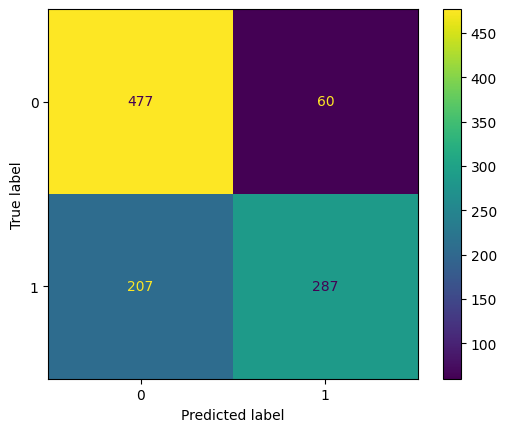

In [47]:
cm = confusion_matrix(yTest, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=clf.classes_)
disp.plot()

0.5542168674698795


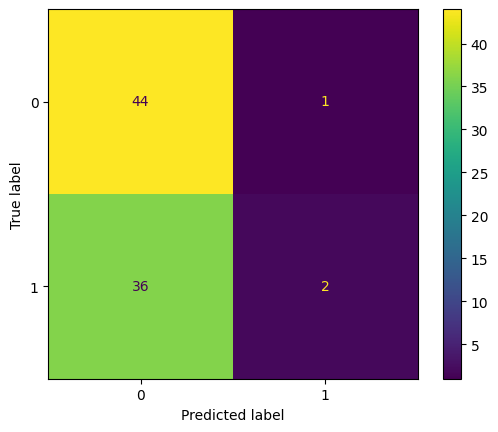

In [48]:
model = joblib.load("DT_model.pkl")
y_pre = clf.predict(X_TestData)
print(accuracy_score(y_TestData, y_pre))
cm = confusion_matrix(y_TestData, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()